In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

In [2]:
dev = qml.device('default.qubit', wires = 2)

In [3]:
@qml.qnode(dev)
def circuit(params):
    A = np.array([[ 0.5, 0.5],
           [ 0.5,  0.5]])
    qml.U3(params[0], params[1], params[2], wires = 0)
    
    return qml.expval(qml.Hermitian(A, wires = 0))

In [4]:
params = [np.pi*0.5, 0, 0.3]
a = circuit(params)
a

0.9999999999999996

In [5]:
def cost(x):
    
    return (1.0 - circuit(x))

In [6]:
init_params = np.array([0.7, 0, 0.3])
cost(init_params)

0.17789115638115482

In [7]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [8]:
for i in range(steps):
    
    params = opt.step(cost, params)
    
print(params)

[1.57079633 0.         0.3       ]


In [9]:
cost(params)

4.440892098500626e-16

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

$|v| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$

In [10]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int) -> np.array:
    """Creates a normalized random complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
    Returns:
        (np.array): normalized complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))

In [11]:
#two qubits -> a complex vector of dimension 4
n_qubits = 3
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [12]:
get_probabilities(psi)

tensor([0.02291557, 0.39770019, 0.08195785, 0.12567407, 0.15402423,
        0.19777694, 0.01717585, 0.0027753 ], requires_grad=True)

## Building the variational quantum circuit in Qiskit

In [13]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    #how many parameters will have given the number_layers
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc
    
def layer(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
#qiskit  odd block
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
#qiskit even block
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [14]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

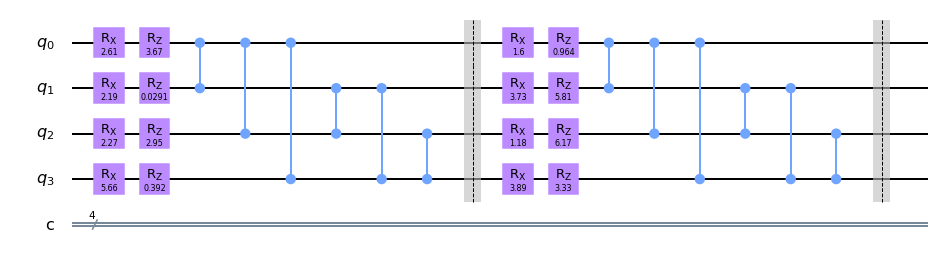

In [15]:
qc.draw(output='mpl')

## Optimization

In [16]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[ 0.14130545+0.05426243j -0.21828528+0.05056519j  0.01431155-0.12850178j
 -0.01799484-0.10659358j -0.11312134+0.27170016j  0.01974972+0.26233738j
 -0.05930685+0.00099888j  0.01615268+0.05049682j  0.26152946-0.38743289j
  0.01903156-0.42528625j  0.12159399-0.00652902j -0.02141493-0.04533206j
 -0.42647817-0.08351368j  0.16345367-0.01451088j  0.05889473-0.16039646j
 -0.17741509-0.206859j  ]


In [17]:
def norm_vector_difference(params):
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.absolute(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

In [18]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

In [19]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Vector:", target_vector)
    print("Obtained Vector:", final_vector)
    print("Norm difference:", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Vector: [0.06192857+0.31093188j 0.04481491+0.08006587j 0.07773294+0.09815953j
 0.07894356+0.12794977j 0.24201993+0.1790527j  0.27954465+0.11334371j
 0.1887093 +0.15529418j 0.08552779+0.22713147j 0.30519862+0.03523396j
 0.11415968+0.1367642j  0.21051282+0.08248315j 0.18134225+0.28156426j
 0.24991763+0.10352037j 0.21082953+0.25573832j 0.06177855+0.18236734j
 0.14842216+0.14488802j]
Obtained Vector: [ 0.15707774+0.00000000e+00j -0.00708823+1.83183685e-01j
 -0.03910266+1.46777765e-01j  0.16940735+5.22248678e-02j
  0.01000222+2.62962700e-01j  0.30711784+2.01789626e-04j
  0.24820953+5.61151272e-02j -0.07664194+2.86929135e-01j
  0.04926697+1.74274919e-01j  0.2054622 -4.95907614e-02j
  0.17511172-2.65271997e-03j -0.00480843+2.04334581e-01j
  0.28861521-9.35747659e-02j  0.09610273+3.40804998e-01j
  0.01559147+2.92984346e-01j  0.34238123-4.96163177e-03j]
Norm difference: 0.7608416683154511
Parameters Found: [1.724682   4.74592017 4.21787666 1.7126537  3.18026802 0.2603

Number of layers: 8
Target Vector: [0.06192857+0.31093188j 0.04481491+0.08006587j 0.07773294+0.09815953j
 0.07894356+0.12794977j 0.24201993+0.1790527j  0.27954465+0.11334371j
 0.1887093 +0.15529418j 0.08552779+0.22713147j 0.30519862+0.03523396j
 0.11415968+0.1367642j  0.21051282+0.08248315j 0.18134225+0.28156426j
 0.24991763+0.10352037j 0.21082953+0.25573832j 0.06177855+0.18236734j
 0.14842216+0.14488802j]
Obtained Vector: [0.04471581+0.19264508j 0.18698552+0.10817553j 0.12786081+0.05498186j
 0.08018517+0.11564483j 0.22376491+0.13895436j 0.3552541 +0.10755555j
 0.17363015+0.14623752j 0.06013696+0.21624585j 0.27204542-0.01045815j
 0.14728302+0.17525769j 0.18416452+0.1333034j  0.17394985+0.31203686j
 0.19531495+0.05269087j 0.23980847+0.28013862j 0.1013303 +0.17068938j
 0.14454855+0.15145702j]
Norm difference: 0.25958615575522415
Parameters Found: [2.02989104 4.03531356 1.5084536  5.65650328 2.68155162 5.23703843
 0.66813692 5.3923476  1.90816332 0.82083659 6.12235801 7.10535454
 4.285522

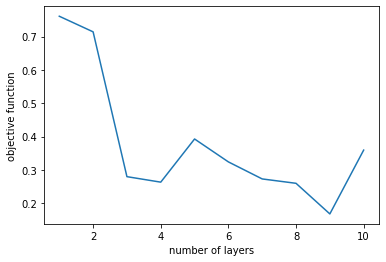

In [20]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

In [21]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Distribution: [0.10051378 0.00841892 0.0156777  0.02260323 0.09063352 0.09099201
 0.05972748 0.05890371 0.09438763 0.03173688 0.05111912 0.11216344
 0.07317529 0.10985118 0.03707443 0.04302168]
Obtained Distribution: [0.0866 0.0755 0.0373 0.0303 0.0902 0.0822 0.0359 0.0325 0.1005 0.0893
 0.0418 0.0316 0.0983 0.0887 0.0439 0.0354]
Output Error (Manhattan Distance): 0.39785183638259425
Parameters Found: [1.51053807 7.41050271 1.55019806 4.65300058 1.28716221 6.68139861
 1.91281404 2.17682274]

Number of layers: 2
Target Distribution: [0.10051378 0.00841892 0.0156777  0.02260323 0.09063352 0.09099201
 0.05972748 0.05890371 0.09438763 0.03173688 0.05111912 0.11216344
 0.07317529 0.10985118 0.03707443 0.04302168]
Obtained Distribution: [0.0974 0.0486 0.0184 0.0293 0.0891 0.0395 0.0202 0.0713 0.0965 0.0438
 0.0275 0.1009 0.0798 0.1193 0.0205 0.0979]
Output Error (Manhattan Distance): 0.31402282475896043
Parameters Found: [5.39396526 4.97144037 4.64307514 1.39442166

Number of layers: 10
Target Distribution: [0.10051378 0.00841892 0.0156777  0.02260323 0.09063352 0.09099201
 0.05972748 0.05890371 0.09438763 0.03173688 0.05111912 0.11216344
 0.07317529 0.10985118 0.03707443 0.04302168]
Obtained Distribution: [0.1078 0.0063 0.0143 0.0259 0.0974 0.0952 0.0583 0.0601 0.1002 0.0388
 0.0609 0.0997 0.0706 0.1134 0.0133 0.0378]
Output Error (Manhattan Distance): 0.0720689964256453
Parameters Found: [ 5.7305189   6.77672289  2.65449015  2.67329335  0.10822005  4.9286061
  5.24078943  5.10269717  0.97515573  2.87048699  4.70523357  3.23008852
  2.75429864  1.06837021  2.64530101  3.36918074  4.02262303  3.61567499
  1.89456553  4.33317095  2.05103154  4.27023536  2.19875062  1.55967783
  3.40190208  6.3578257   0.83655726  3.55442678  2.38360191  4.91801731
  0.70656934  0.36699893  4.61163682  5.05814277  1.18525408  4.3933793
  1.03490421 -0.22064236  4.79223115  0.42944719  6.27139352  2.79949985
  2.96642653  3.12920626  2.35186526  0.18787148  5.9758244

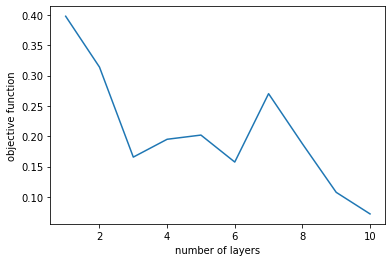

In [22]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

## Optimize the variational circuit using Pennylane

In [104]:
dev = qml.device('default.qubit', wires = 4)

In [105]:
target_vector = target_vector.reshape((16,1))
density_matrix = target_vector @ np.transpose(np.conjugate(target_vector))
print(density_matrix.shape)

(16, 16)


In [106]:
def layer(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(params[:int(n_parameters/2)])
        even_block(params[int(n_parameters/2):])

def odd_block(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [107]:
@qml.qnode(dev)
def var_circuit(params):

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [108]:
def cost(x):
    
    return (1.0 - var_circuit(x))

In [109]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

cost(params)

0.8785690924786405

In [110]:
init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

In [111]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [112]:
for number_layers in range(1,):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))

0.4950981822579128
0.11540618198706631
0.059856900892810705
0.0421415018030622
